# Example 2: A Regression Task
## Introduction
The following code cells show the use of the `Trainer` class, on a more realistic case.

Dataset used: Bike sharing. The objective for the regression problem is to estimate the number of bike rents as a function of the instant in the day (in the hourly resoluted case) and the meteorological conditions.

Dataset citation: H. Fanaee-T. "Bike Sharing," UCI Machine Learning Repository, 2013. [Online]. Available: [https://doi.org/10.24432/C5W894](https://doi.org/10.24432/C5W894).

## Example
### Imports and dataset preparation
We define a basic sketch of a project, with data preprocessing, evaluation and models classes and modules.
Data are retrieved as inputs and outputs, see the documentation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import (
    mean_absolute_error,
    root_mean_squared_error,
    r2_score
)

from tqdm.notebook import tqdm

from mlght.core.training import Trainer
from mlght.core.scalers import ResettableStandardScaler
from mlght.utils.postprocessing import ParametersDenormalization

In [2]:
# Prepare the skeleton of a possible data science project
class DataPreparation:
    """
    Data preparation module.
    """
    @staticmethod
    def prepare_data(path):
        data = pd.read_csv(path)
        # Features cleaning
        data.drop(['instant', 'dteday', 'casual', 'registered'], axis = 1, inplace = True)
        
        # Convert integers to categorical type
        categorical_features = ['season', 'yr', 'mnth', 'hr', 'weekday', 'weathersit']
        for col in categorical_features:
            data[col] = data[col].astype('category')
        
        # One-Hot Encode the categorical variables
        data_encoded = pd.get_dummies(data, columns = categorical_features, drop_first = True)

        # Split in input, output, return
        X = data_encoded.drop('cnt', axis = 1)
        y = data_encoded[['cnt']]
        return X, y

class EvaluationFramework:
    """
    Evaluation framework module.
    """
    @staticmethod
    def plot_groundtruth_predictions(ytrue, ypred):
        fig, ax = plt.subplots(figsize = (7.5, 4.5))
        ax.scatter(
            ytrue.values,
            ypred.values,
            c = "tab:blue",
            alpha = 0.75
        )
        ax.set_xlabel("True values", fontsize = 12)
        ax.set_ylabel("Predicted values", fontsize = 12)
        ax.grid(lw = 0.5, ls = ":")
        plt.show()

In [3]:
X, y = DataPreparation.prepare_data("./dataset/hour.csv")

### Trainer instantiation

In [4]:
from sklearn.ensemble import RandomForestRegressor
import warnings

# Some scikit-learn models raise a warning if the
# y object is not a flat array. The underlying 
# model in this framework works with dataframes.
# As of the current version, this choice is kept,
# and the warning in simply suppressed
warnings.filterwarnings("ignore")

# Trainer instantiation
# Note: Since RandomForestRegressor is yet an
# ensemble method, the n_estimators in the trainer
# constructor is set to 1.
trainer = Trainer(
    base_estimator = RandomForestRegressor,
    estimator_name = "RandomForestRegressor",
    estimator_kwargs = {
        "n_estimators" : 10,
        "n_jobs" : -1
    },
    n_cv_splits = 5,
    n_estimators = 1,
    eval_metrics = {
        "MAE": mean_absolute_error,
        "RMSE": root_mean_squared_error,
        "R2": r2_score
    },
    input_normalizer = ResettableStandardScaler,
    target_normalizer = ResettableStandardScaler,
    pbar_module = tqdm
)

Xtrain, ytrain, Xtest, ytest = trainer.split_data(X, y)

### K-fold cross validation

In [5]:
trainer.run_kfold_cv(Xtrain, ytrain)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

+----------+-------------------+
| Metric   | cnt               |
+==========+===================+
| MAE      | 23.0091 ± 9.4456  |
+----------+-------------------+
| R2       | 0.9537 ± 0.0387   |
+----------+-------------------+
| RMSE     | 36.7152 ± 14.5843 |
+----------+-------------------+


### Model fit and prediction

In [6]:
trainer.fit(Xtrain, ytrain)
ypred = trainer.predict(Xtest, columns = ytest.columns, index = ytest.index)
_ = trainer.evaluate(ytest, ypred, print_metrics = True)

  0%|          | 0/1 [00:00<?, ?it/s]


------------
Evaluation: 

+------+-----------+
|      |       cnt |
+======+===========+
| MAE  | 36.383    |
+------+-----------+
| RMSE | 56.8287   |
+------+-----------+
| R2   |  0.902955 |
+------+-----------+


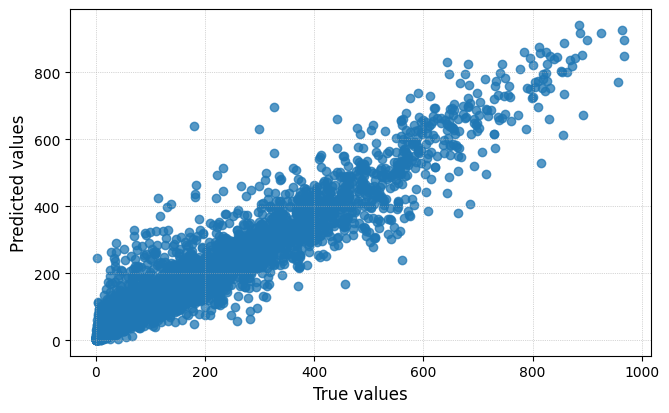

In [7]:
EvaluationFramework.plot_groundtruth_predictions(ytest, ypred)

### Test 1: Plain `sklearn` comparison

In [8]:
model = RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1)
model.fit(Xtrain, ytrain)

ypred = model.predict(Xtest)
r2 = r2_score(ytest, ypred)

print(f"\nRandom Forest R2 Score: {r2:.4f}")


Random Forest R2 Score: 0.9012


## Example: Beyond `sklearn`
We may want to use different models. The `mlght` framework supports any model that implements `fit` and `predict` methods.

Here we define a simple PyTorch model and train it via the `Trainer` interface.

### Define `torch` Dataset and Module

Note that the derived `nn.Module` is a PyTorch module which implements fit and predict methods. This makes the model fully compatible with the `Trainer` class.

In [9]:
from dataclasses import dataclass
import torch
from torch import nn

In [10]:
@dataclass
class Hyperparams:
    def __init__(
            self,
            epochs,
            batch_size,
            learning_rate,
            weight_decay
        ):
        self.epochs        = epochs
        self.batch_size    = batch_size
        self.learning_rate = learning_rate
        self.weight_decay  = weight_decay
    #end
#end

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X.to_numpy())
        self.y = torch.Tensor(y.to_numpy())
        self.features_names = X.columns
        self.label_name = y.columns
    #end
    
    def __getitem__(self, idx):
        return (self.X[idx], self.y[idx])
    #end
    
    def __len__(self):
        return len(self.X)
    #end
#end

class NeuralNetwork(nn.Module):
    def __init__(
            self,
            layers,
            pbar_module,
            epochs,
            batch_size,
            learning_rate,
            weight_decay
        ):
        super(NeuralNetwork, self).__init__()

        # Model definition
        self.model = nn.Sequential(
            *self._make_layers(layers)
        )

        # Hyper-parameters
        self.hparams = Hyperparams(
            epochs        = epochs,
            batch_size    = batch_size, 
            learning_rate = learning_rate,
            weight_decay  = weight_decay 
        )

        self.pbar_module = pbar_module
    #end

    def _make_layers(self, layers):
        net_layers = []
        for i in range(len(layers) - 1):
            if i == len(layers) - 2:
                net_layers.append(
                    nn.Linear(layers[i], layers[i+1])
                )
            else:
                net_layers.append(
                    nn.Linear(layers[i], layers[i+1])
                )
                net_layers.append(
                    nn.ReLU()
                )
        return net_layers
    
    def forward(self, data):
        output = self.model(data)
        return output

    def fit(self, X, y):
        train_loader = torch.utils.data.DataLoader(
            dataset = Dataset(X, y),
            batch_size = self.hparams.batch_size
        )
        
        opt = torch.optim.Adam(
            self.model.parameters(),
            lr = self.hparams.learning_rate,
            weight_decay = self.hparams.weight_decay
        )
        l2loss = nn.MSELoss(reduction = "mean")
        l1loss = nn.L1Loss(reduction = "mean")
        
        losses = []
        pbar_epochs = self.pbar_module(
            total = self.hparams.epochs,
            colour = "green",
            position = 2, leave = False
        )
        for epoch in range(self.hparams.epochs):
            pbar_epochs.set_description(f"Epoch: {epoch}")
            
            rloss = 0
            for x, y in train_loader:
                opt.zero_grad()
                y_ = self.forward(x)
                loss = 1.15 * l2loss(y_, y) + 0.75 * l1loss(y_, y)
                loss.backward()
                opt.step()
                rloss += loss.item() / x.shape[0]
            #end
            losses.append(rloss)
            
            pbar_epochs.update()
        #end
        
        self.losses = losses
        self.coef_ = [self.parameters()]
        self.intercept_ = None
    #end

    def predict(self, X):
        self.model.eval()
        ypred = self.model(torch.Tensor(X.to_numpy()))
        return ypred.detach().numpy()
    #end
#end

### Instantiate the trainer
Note: Using a PyTorch neural network adds an element of complexity. The estimator keyword arguments dictionary should contain all the information needed to initialize the model. The specific implementation is case-specific and largely left to the user.

In [11]:
base_estimator = NeuralNetwork
estimator_kwargs = dict(
    layers = [
        len(X.columns),
        32,
        16,
        8,
        len(y.columns)
    ],
    pbar_module = tqdm,
    epochs = 50,
    batch_size = 512,
    learning_rate = 0.001,
    weight_decay = 1e-5
)

trainer = Trainer(
    base_estimator = base_estimator,
    estimator_name = "MultiLayerPerceptron",
    estimator_kwargs = estimator_kwargs,
    n_cv_splits = 5,
    n_estimators = 10,
    eval_metrics = {
        "MAE": mean_absolute_error,
        "RMSE": root_mean_squared_error,
        "R2": r2_score
    },
    input_normalizer = ResettableStandardScaler,
    target_normalizer = ResettableStandardScaler,
    pbar_module = tqdm
)

### Model train and predict
Depending on the hardware, but the neural network takes some more time to train. More complex cases may justify the use of deep learning-based models. This section aimed to show how `mlght` supports PyTorch models as well.

In [12]:
trainer.fit(Xtrain, ytrain)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [13]:
ypred = trainer.predict(Xtest, columns = ytest.columns, index = ytest.index)
_ = trainer.evaluate(ytest, ypred, print_metrics = True)


------------
Evaluation: 

+------+-----------+
|      |       cnt |
+======+===========+
| MAE  | 24.6554   |
+------+-----------+
| RMSE | 39.639    |
+------+-----------+
| R2   |  0.952784 |
+------+-----------+


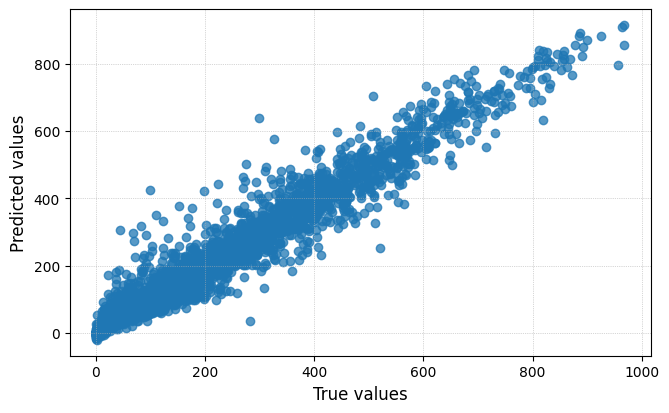

In [14]:
EvaluationFramework.plot_groundtruth_predictions(ytest, ypred)